<a href="https://colab.research.google.com/github/adeakinwe/computer_vision/blob/main/overfitting_prevention_L2_dropout_earlystopping_batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

IMG_HEIGHT = 16
IMG_WIDTH = 16
IMG_CHANNELS = 3

CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

In [2]:
def read_and_decode(filename, resize_dims):
    # 1. Read the raw file
    img_bytes = tf.io.read_file(filename)
    # 2. Decode image data
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    # 3. Convert pixel values to floats in [0, 1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize the image to match desired dimensions
    img = tf.image.resize(img, resize_dims)
    return img

In [3]:
def parse_csvline(csv_line):
    # record_defaults specify the data types for each column
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)

    # Load the image
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])

    # Convert label string to integer based on the CLASS_NAMES index
    label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
    return img, label

In [4]:
# Define datasets
train_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)

eval_dataset = (
    tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
    .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(8)
    .prefetch(tf.data.AUTOTUNE)
)

In [5]:
for image_batch, label_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    print("Labels:", label_batch.numpy())

Image batch shape: (8, 16, 16, 3)
Label batch shape: (8,)
Labels: [0 1 1 1 0 2 1 0]


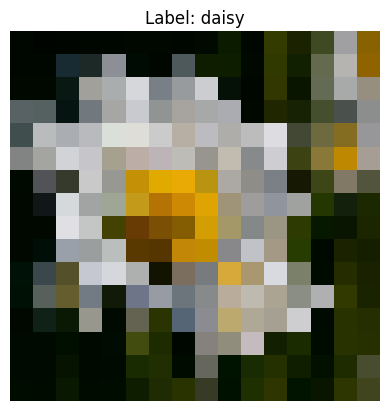

In [6]:
import matplotlib.pyplot as plt

for image_batch, label_batch in train_dataset.take(1):
    # Take the first image from the batch
    first_image = image_batch[0]
    first_label = label_batch[0]

    # Convert tensor to numpy array
    plt.imshow(first_image.numpy())
    plt.title(f"Label: {CLASS_NAMES[first_label]}")
    plt.axis('off')
    plt.show()

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

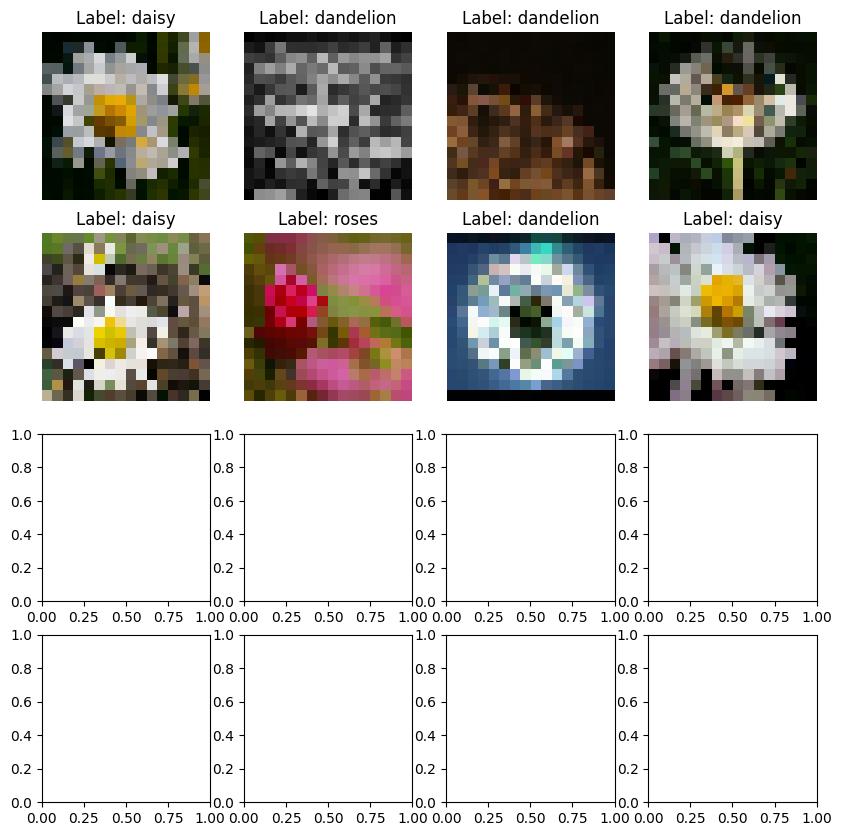

In [ ]:
import matplotlib.pyplot as plt

# Take one batch from the dataset
for image_batch, label_batch in train_dataset.take(2):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Create a 4x4 grid

    for i in range(16):  # Loop over the first 16 images
        ax = axes[i // 4, i % 4]  # Determine grid position
        ax.imshow(image_batch[i].numpy())  # Convert tensor to numpy array
        ax.set_title(f"Label: {CLASS_NAMES[label_batch[i]]}")
        ax.axis("off")  # Hide axes

    plt.tight_layout()
    plt.show()

In [9]:
from tensorflow import keras

regularizer = tf.keras.regularizers.l1_l2(l1=0, l2=0.1)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    keras.layers.Dense(128, kernel_regularizer=regularizer),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(len(CLASS_NAMES), kernel_regularizer=regularizer),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("softmax"),
    keras.layers.Dropout(0.5)
])

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # What to monitor ('val_loss' is common)
    patience=3,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [10]:
EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=eval_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/10
    413/Unknown 399s 949ms/step - accuracy: 0.2392 - loss: 16.4199

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.2393 - loss: 16.4084 - val_accuracy: 0.3189 - val_loss: 2.2015
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.2577 - loss: 8.6408 - val_accuracy: 0.3919 - val_loss: 2.2338
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 390s 928ms/step - accuracy: 0.2818 - loss: 8.3247 - val_accuracy: 0.2378 - val_loss: 4.1085
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 442s 930ms/step - accuracy: 0.2709 - loss: 8.3772 - val_accuracy: 0.3297 - val_loss: 2.8561


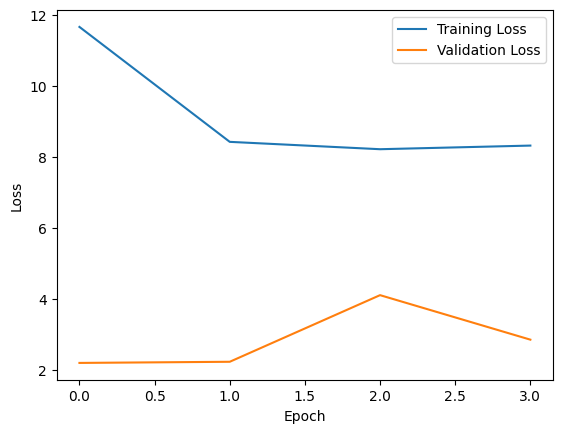

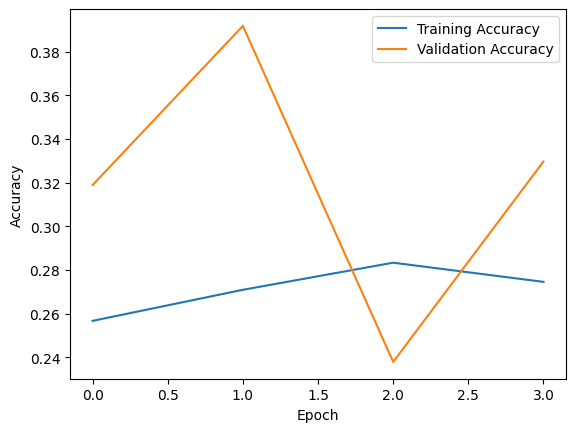

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


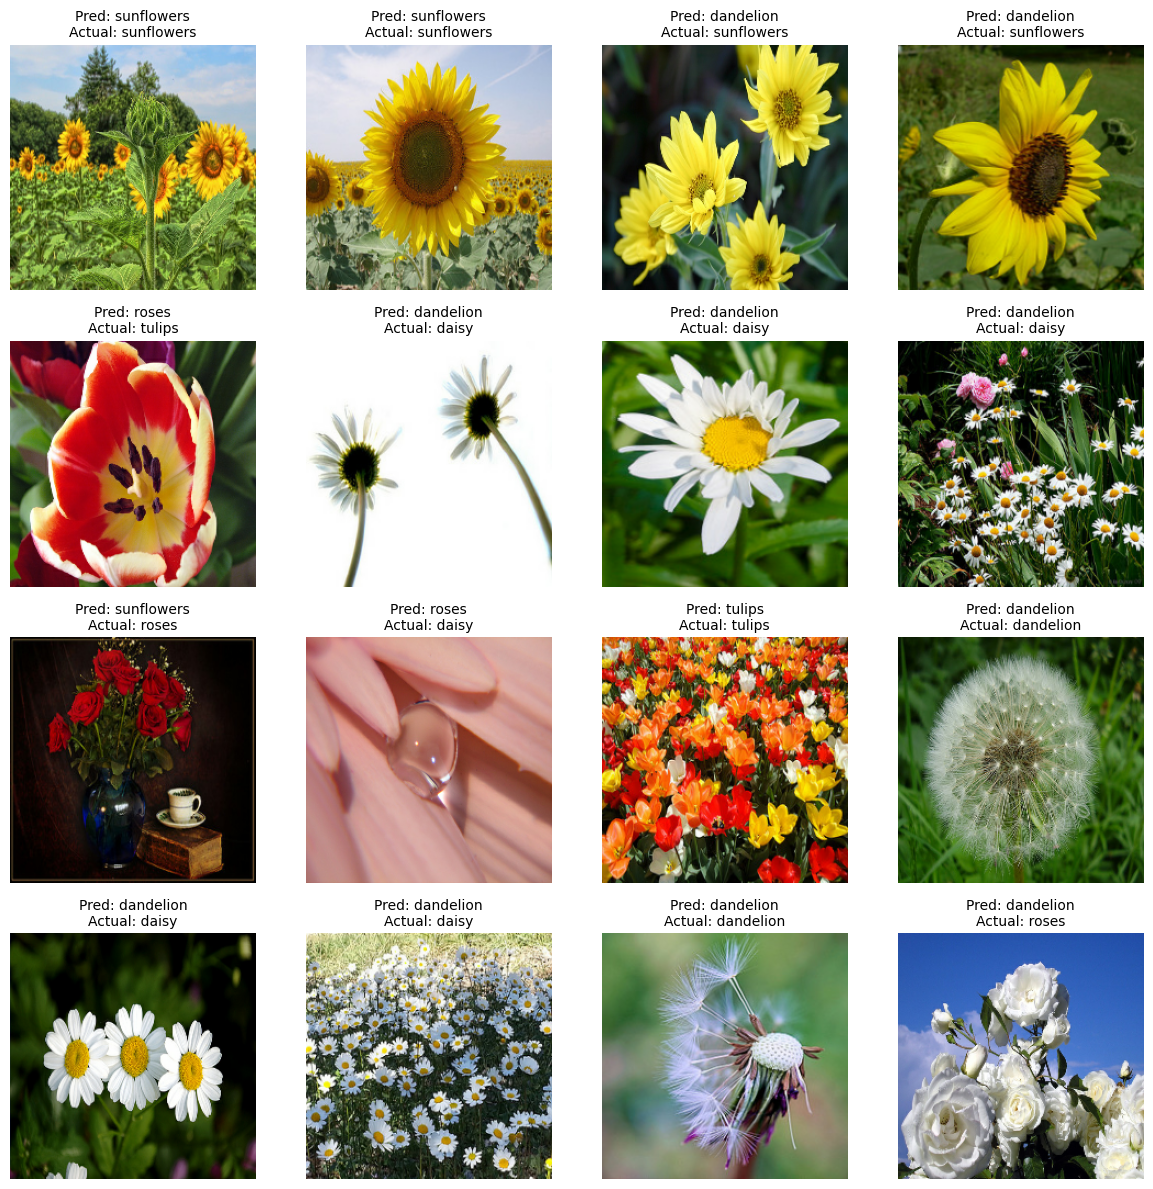

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Take exactly one batch from the evaluation dataset
for images, labels in eval_dataset.take(1):
    # Get model predictions for this batch
    batch_predictions = model.predict(images)
    predicted_indices = np.argmax(batch_predictions, axis=1)

    # Number of images in this batch
    num_images = images.shape[0]

    # Configure how many images to display per row
    num_cols = 4
    num_rows = math.ceil(num_images / num_cols)

    # Create a figure with a suitable size
    plt.figure(figsize=(12, 3 * num_rows))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)

        # Display the image
        plt.imshow(images[i].numpy())
        plt.axis('off')

        # Get predicted and actual class names
        pred_class = CLASS_NAMES[predicted_indices[i]]
        actual_class = CLASS_NAMES[labels[i].numpy()]

        # Show both predicted and actual labels as title
        plt.title(f"Pred: {pred_class}\nActual: {actual_class}", fontsize=10)

    # Adjust spacing to avoid overlapping titles, etc.
    plt.tight_layout()
    plt.show()